In [62]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import statistics as st
import seaborn as sns
import datetime 
from scipy.stats import f_oneway




We need to know:
- How many customers were there for each approach?
- What does the spread of the revenue look like overall? And for each method?
- Was there any difference in revenue over time for each of the methods?
- Based on the data, which method would you recommend we continue to use? Some
of these methods take more time from the team so they may not be the best for us
to use if the results are similar.

In [3]:
df = pd.read_csv("product_sales.csv")

In [4]:
df.head()

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,NaN,0,24,Arizona
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,NaN,3,25,Indiana
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   week               15000 non-null  int64  
 1   sales_method       15000 non-null  object 
 2   customer_id        15000 non-null  object 
 3   nb_sold            15000 non-null  int64  
 4   revenue            13926 non-null  float64
 5   years_as_customer  15000 non-null  int64  
 6   nb_site_visits     15000 non-null  int64  
 7   state              15000 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [14]:
df.describe()

,week,nb_sold,revenue,years_as_customer,nb_site_visits
count,15000.000000,15000.000000,13926.000000,15000.000000,15000.000000
mean,3.098267,10.084667,93.934943,4.965933,24.990867
std,1.656420,1.812213,47.435312,5.044952,3.500914
min,1.000000,7.000000,32.540000,0.000000,12.000000
25%,2.000000,9.000000,52.470000,1.000000,23.000000
50%,3.000000,10.000000,89.500000,3.000000,25.000000
75%,5.000000,11.000000,107.327500,7.000000,27.000000
max,6.000000,16.000000,238.320000,63.000000,41.000000


# Data Validation

## Checking unique values

In [ ]:
# Checking unique values
unique_values = df.nunique()
print ((f"\n🚨 Unique Values: {unique_values}"))


🚨 Unique Values: week                     6
sales_method             5
customer_id          15000
nb_sold                 10
revenue               6743
years_as_customer       42
nb_site_visits          27
state                   50
dtype: int64


- we can see 5 sales methods, where there should only be 3 (call, email, call + email)
- 42 unique values in year_as_costumer, when the company has been only opened for 40 years. 


In [ ]:
np.sort(df["years_as_customer"].unique())


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 47, 63])

In [99]:
df[df["years_as_customer"] > 40]

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state,year_as_customer


We will replace this values > 40 years with the median year_as_costumer (3 years)

In [ ]:
df["years_as_customer"] = df["years_as_customer"].replace({47:3, 63:3})

In [ ]:
np.sort(df["years_as_customer"].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

In [ ]:
# Visualizing sales_method unique values
df["sales_method"].unique()

array(['Email', 'Email + Call', 'Call', 'em + call', 'email'],
      dtype=object)

In [ ]:
# normalizing text to lower case 
df = df.map(lambda s: s.lower() if type(s) == str else s)

In [ ]:
# replacing the misspelled values
df["sales_method"] = df["sales_method"].replace({"em + call":"email + call"})

In [ ]:
# verifying the changes to the df
df["sales_method"].unique()

array(['email', 'email + call', 'call'], dtype=object)

## Dealing with Missing values

In [ ]:
# Identifying missing values
missing_values = df.isnull().sum()
print("\n🚨 Missing Values:\n", missing_values[missing_values > 0])


🚨 Missing Values:
 revenue    1074
dtype: int64


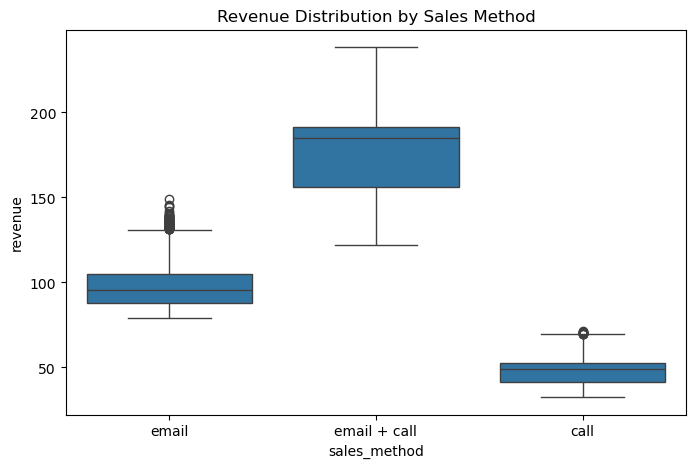

In [ ]:
# Visualizing revenue distribution by Sales Method with a boxplot

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(x="sales_method", y="revenue", data=df)
plt.title("Revenue Distribution by Sales Method")
plt.show()

there are clear differences in median revenue across methods, which suggests a relationship.
Since the data is not normally distributed, the Kruskal-Wallis test is a better choice because it's a non-parametric alternative to ANOVA. It compares the median revenue across sales methods rather than means.

In [80]:
# checking distribution of sales for the different sales methods
email = df[df["sales_method"]=="email"]
email_call = df[df["sales_method"]=="email + call"]
call = df[df["sales_method"]=="call"]

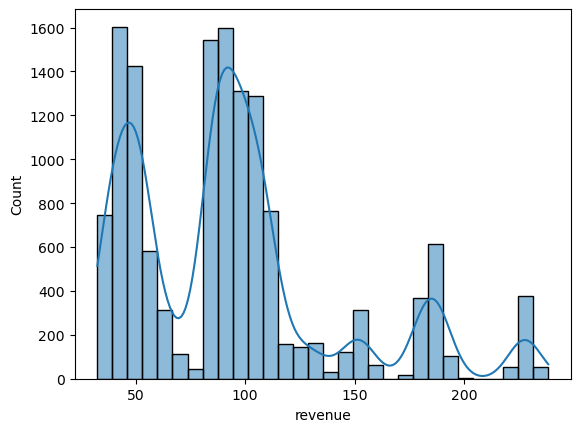

In [78]:
sns.histplot(df["revenue"], kde=True, bins=30)
plt.show()

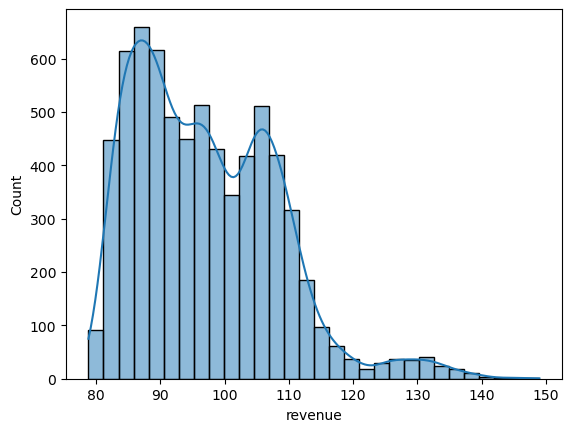

In [79]:
sns.histplot(email["revenue"], kde=True, bins=30)
plt.show()

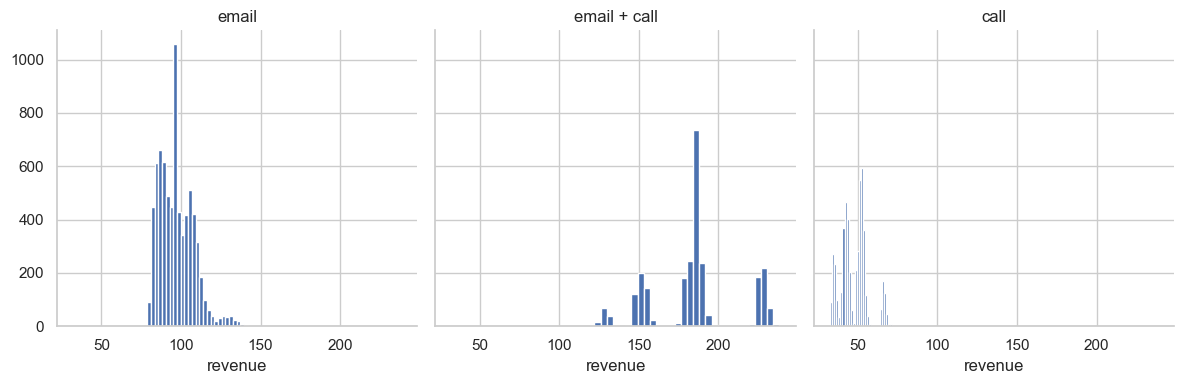

In [126]:
#Visualizing revenue distribution in different sales_method categories

sns.set(style="whitegrid")

g = sns.FacetGrid(df, col="sales_method", col_wrap=3, height=4)

# Map a histogram for 'revenue' onto the grid
g.map(plt.hist, "revenue", bins=30)

# Add titles
g.set_titles("{col_name}")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

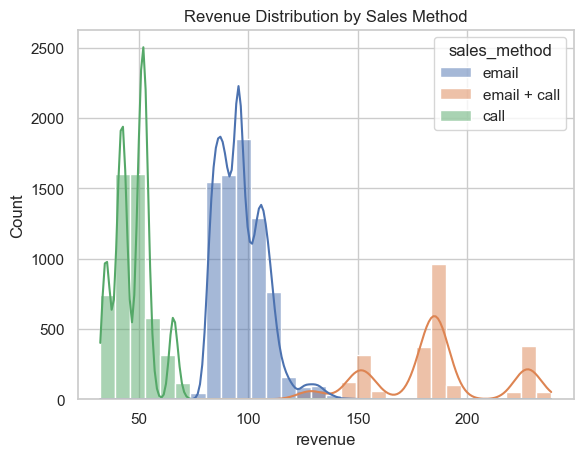

In [125]:
sns.histplot(df, x="revenue", hue="sales_method", kde=True, bins=30)
plt.title("Revenue Distribution by Sales Method")
plt.show()

sales methods align with the peaks, this confirms that method impacts revenue.

In [76]:
from scipy.stats import kruskal

# Get revenue values for each sales method
groups = [df[df["sales_method"] == method]["revenue"].dropna() for method in df["sales_method"].unique()]

# Perform Kruskal-Wallis test
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis test statistic: {stat}")
print(f"p-value: {p}")

Kruskal-Wallis test statistic: 11585.867887633392
p-value: 0.0


Imputation of  mising revenue values with median per sales_method
Since the median is more robust to skewed distributions, it's a good imputation strategy

In [ ]:
##  Calculate median revenue  by sales method
sales_method_revenue = df.groupby("sales_method")["revenue"].median()

# Convert to a dictionary
revenue_dict = sales_method_revenue.to_dict()

# Map the dictionary to missing values of revenue by sales method
df["revenue"] = df["revenue"].fillna(df["sales_method"].map(revenue_dict))

# Check for missing values
print(df.isna().sum())

sales_method
call             49.07
email            95.58
email + call    184.74
Name: revenue, dtype: float64
week                     0
sales_method             0
customer_id              0
nb_sold                  0
revenue                  0
years_as_customer        0
nb_site_visits           0
state                    0
year_as_customer     15000
dtype: int64


## Detecting Duplicates

In [ ]:
duplicates = df.duplicated().sum()
print(f"\n🚨 Duplicate Records Found: {duplicates}")


🚨 Duplicate Records Found: 0


# EDA

- How many customers were there for each approach?
- What does the spread of the revenue look like overall? And for each method?
- Was there any difference in revenue over time for each of the methods?
- Based on the data, which method would you recommend we continue to use? Some
of these methods take more time from the team so they may not be the best for us
to use if the results are similar.

In [ ]:
# 1) how many costumers where there for each approach? 

In [102]:
group = df.groupby("sales_method").size().reset_index(name ="customer_count")
group

,sales_method,customer_count
0,call,4962
1,email,7466
2,email + call,2572


Text(0.5, 1.0, 'Customer Count by Sales Method')

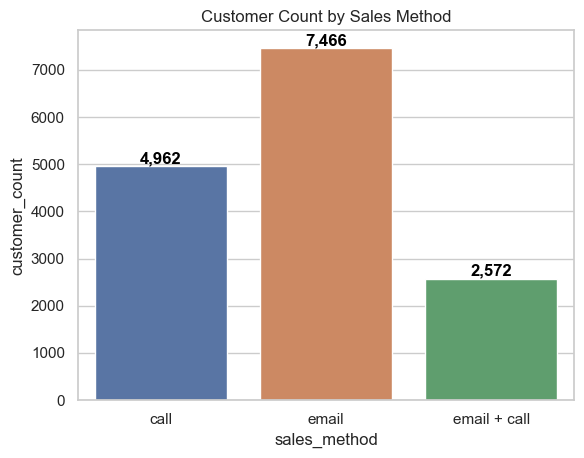

In [124]:
ax= sns.barplot(data=group, x="sales_method", y= "customer_count", hue ="sales_method")
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}',  # Format as integer with comma
                 (p.get_x() + p.get_width() / 2, p.get_height()),  # Position
                 ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.title("Customer Count by Sales Method")

In [ ]:
    # What does the spread of the revenue look like overall? And for each method?

In [120]:
print("Overall Revenue Statistics:")
print(df["revenue"].describe())

print("\nRevenue Statistics by Sales Method:")
print(df.groupby("sales_method")["revenue"].describe())

Overall Revenue Statistics:
count    15000.000000
mean        95.565964
std         47.985182
min         32.540000
25%         52.650000
50%         90.950000
75%        107.750000
max        238.320000
Name: revenue, dtype: float64

Revenue Statistics by Sales Method:
               count        mean        std     min       25%     50%  \
sales_method                                                            
call          4962.0   47.651181   8.455884   32.54   41.6300   49.07   
email         7466.0   97.014914  10.801764   78.83   88.3900   95.58   
email + call  2572.0  183.798970  27.040536  122.11  176.4375  184.74   

                  75%     max  
sales_method                   
call           52.590   71.36  
email         104.460  148.97  
email + call  189.535  238.32  


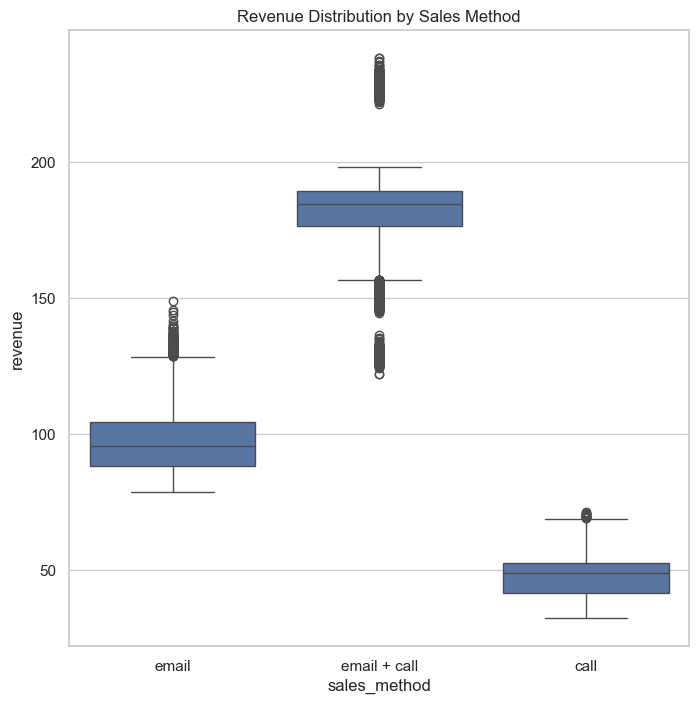

In [130]:
# Visualizing revenue distribution by Sales Method with a boxplot

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.boxplot(x="sales_method", y="revenue", data=df)
plt.title("Revenue Distribution by Sales Method")
plt.show()


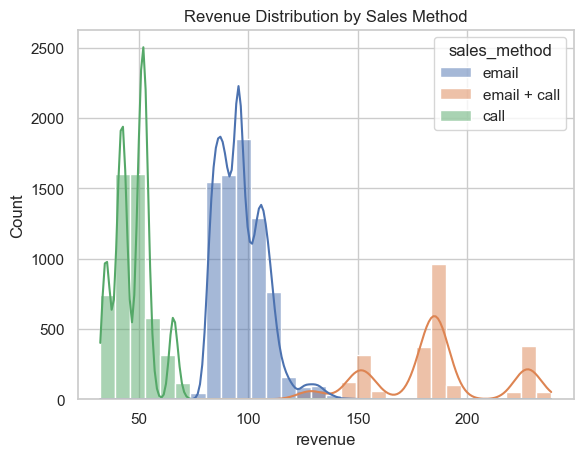

In [122]:
sns.histplot(df, x="revenue", hue="sales_method", kde=True, bins=30)
plt.title("Revenue Distribution by Sales Method")
plt.show()

How to Interpret the Results?
🔹 Overall Revenue Spread

Is the mean much higher than the median? → Suggests skewed revenue (some very high values pulling the average up).
Is there a lot of variance? → If standard deviation is high, revenue varies greatly.
Are there outliers? → Look at the min/max values and boxplot.

🔹 Revenue Spread for Each Method

Does one method have a higher median revenue? → Suggests it generates better sales.
Does one method have a wider spread (more variability)? → Suggests revenue is inconsistent.
Do some methods have outliers? → Maybe high-revenue deals are only happening with certain methods.
Example Interpretation
✅ If revenue is highly skewed:
→ There are a few high-revenue deals pulling up the mean, while most transactions are smaller.

✅ If one method has a much higher median revenue:
→ That method is consistently performing better.

✅ If one method has a lot of variance:
→ Its performance is unpredictable; sometimes it generates high revenue, sometimes low.